# EDA Steam Games 

Exploratory data analysis (EDA) is a fundamental phase in the process of understanding and preparing data. In this case, we have a dataset related to games from Steam, a digital distribution platform for video games. This EDA will focus on exploring the different characteristics of the games present in the dataset.


In this phase, we are going to use Python and some of its libraries, such as pandas, matplotlib and seaborn, to explore and visualize our dataset.

In [3]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()
work_dir = os.getenv("WORK_DIR")

sys.path.append(work_dir)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.orm import sessionmaker, aliased
from src.database.db_connection import get_engine
from src.models.SteamGames_models import Games


C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_15512\1262648629.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Conected successfully to database PruebaCarga!


Load dataset

In [5]:
connection = get_engine()

Session = sessionmaker(bind=connection)
session = Session()

Conected successfully to database PruebaCarga!


In [6]:
table = aliased(Games)
query = session.query(table).statement
games = pd.read_sql(query, connection)


Concise summary of the dataframe, including the number of rows and columns, the column names, the data types in each column, and the number of non-null values present in each column.

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85103 entries, 0 to 85102
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AppID                    85103 non-null  int64  
 1   Name                     85097 non-null  object 
 2   ReleaseDate              85103 non-null  object 
 3   EstimatedOwners          85103 non-null  object 
 4   PeakCCU                  85103 non-null  int64  
 5   RequiredAge              85103 non-null  int64  
 6   Price                    85103 non-null  float64
 7   DLCCount                 85103 non-null  int64  
 8   AboutTheGame             81536 non-null  object 
 9   SupportedLanguages       85103 non-null  object 
 10  FullAudioLanguages       85103 non-null  object 
 11  Reviews                  9743 non-null   object 
 12  HeaderImage              85103 non-null  object 
 13  Website                  39452 non-null  object 
 14  SupportUrl            

Detailed summary of the DataFrame games, including information about columns, data types, missing values, number of rows, and number of unique values.

In [8]:
df_summary = {
    'columns': games.columns,
    'types': games.dtypes,
    'missing': games.isna().sum(),
    'size': games.shape[0]
}

print(pd.DataFrame(df_summary))

                                         columns    types  missing   size
AppID                                      AppID    int64        0  85103
Name                                        Name   object        6  85103
ReleaseDate                          ReleaseDate   object        0  85103
EstimatedOwners                  EstimatedOwners   object        0  85103
PeakCCU                                  PeakCCU    int64        0  85103
RequiredAge                          RequiredAge    int64        0  85103
Price                                      Price  float64        0  85103
DLCCount                                DLCCount    int64        0  85103
AboutTheGame                        AboutTheGame   object     3567  85103
SupportedLanguages            SupportedLanguages   object        0  85103
FullAudioLanguages            FullAudioLanguages   object        0  85103
Reviews                                  Reviews   object    75360  85103
HeaderImage                          H

We made a bar chart showing the number of columns of each type of data in the DataFrame games.

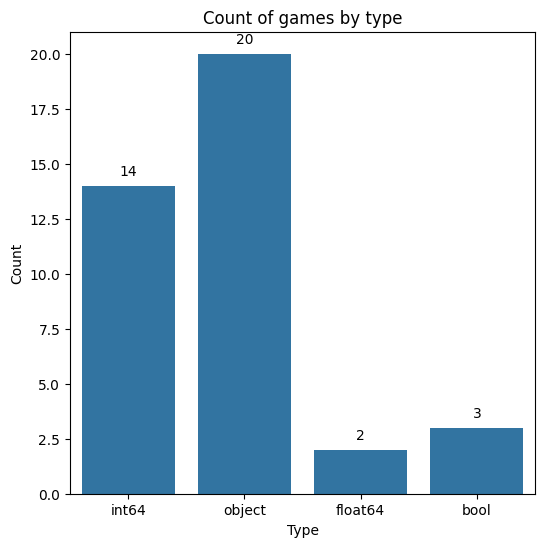

In [9]:
# Crear la gráfica de barras
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='types', data=df_summary)

# Agregar los valores encima de las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Añadir etiquetas y título
plt.title('Count of games by type')
plt.xlabel('Type')
plt.ylabel('Count')

# Mostrar la gráfica
plt.show()

### Delete Column

Release Date 

In [8]:
games['ReleaseDate'] = pd.to_datetime(games['ReleaseDate'], format='mixed')
games.head(2)

,AppID,Name,ReleaseDate,EstimatedOwners,PeakCCU,RequiredAge,Price,DLCCount,AboutTheGame,SupportedLanguages,...,AveragePlaytimeTwoWeeks,MedianPlaytimeForever,MedianPlaytimeTwoWeeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,"[[, ', E, n, g, l, i, s, h, ', ]]",...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"[[, ', E, n, g, l, i, s, h, ', ,, , ', F, r, ...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


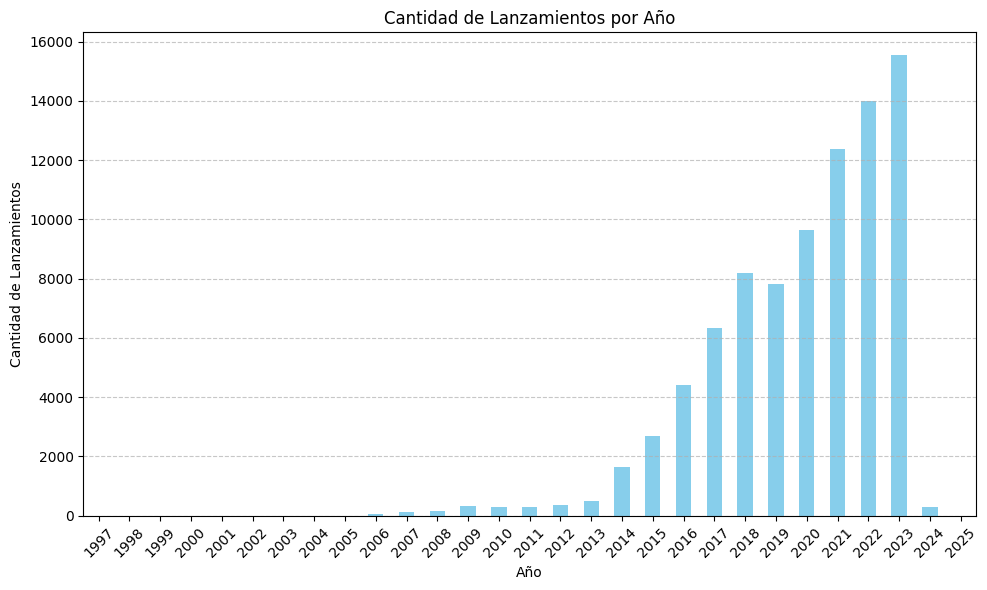

In [8]:
games['Year'] = games['ReleaseDate'].dt.year
games['Month'] = games['ReleaseDate'].dt.month

# Contar la cantidad de lanzamientos por año y por mes
release_by_year = games['Year'].value_counts().sort_index()
release_by_month = games.groupby('Month')['Name'].count()

# Crear gráfico de barras para la cantidad de lanzamientos por año
plt.figure(figsize=(10, 6))
release_by_year.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Lanzamientos por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Lanzamientos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Name nullos 

In [11]:
games.loc[games['Name'].isna()].index

Index([25274, 72113, 77259, 77540, 77612, 77666], dtype='int64')

In [12]:
#Delete null names 
games = games.drop(games.loc[games['Name'].isna()].index)
games.isna().sum()

AppID                          0
Name                           0
ReleaseDate                    0
EstimatedOwners                0
PeakCCU                        0
RequiredAge                    0
Price                          0
DLCCount                       0
AboutTheGame                3562
SupportedLanguages             0
FullAudioLanguages             0
Reviews                    75354
HeaderImage                    0
Website                    45645
SupportUrl                 43511
SupportEmail               13590
Windows                        0
Mac                            0
Linux                          0
MetacriticScore                0
MetacriticUrl              81185
UserScore                      0
Positive                       0
Negative                       0
ScoreRank                  85053
Achievements                   0
Recommendations                0
Notes                      72079
AveragePlaytimeForever         0
AveragePlaytimeTwoWeeks        0
MedianPlay

In [13]:
games.loc[games['AboutTheGame'].isna(),"Name"]

10           Rogue Company Playtest
11        Celestial Empire Playtest
107                  溪风谷之战 Playtest
191           Burial Stone Playtest
226       Emperial Knights Playtest
                    ...            
85004              Elysium Playtest
85042              Dastaan Playtest
85063                    SlipBreak™
85089     Backpack Battles Playtest
85095    Scorching Engines Playtest
Name: Name, Length: 3562, dtype: object

Imputacion About the Game

In [9]:
games['AboutTheGame'].fillna('', inplace=True)


C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_15512\1966714665.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['AboutTheGame'].fillna('', inplace=True)


In [10]:
games.isna().sum()

AppID                          0
Name                           6
ReleaseDate                    0
EstimatedOwners                0
PeakCCU                        0
RequiredAge                    0
Price                          0
DLCCount                       0
AboutTheGame                   0
SupportedLanguages             0
FullAudioLanguages             0
Reviews                    75360
HeaderImage                    0
Website                    45651
SupportUrl                 43517
SupportEmail               13596
Windows                        0
Mac                            0
Linux                          0
MetacriticScore                0
MetacriticUrl              81191
UserScore                      0
Positive                       0
Negative                       0
ScoreRank                  85059
Achievements                   0
Recommendations                0
Notes                      72082
AveragePlaytimeForever         0
AveragePlaytimeTwoWeeks        0
MedianPlay

SupportedLanguages

Conocer la cantidad de idiomas que se pueden utilizar en el juego 

In [53]:
games.head()

,AppID,Name,ReleaseDate,EstimatedOwners,PeakCCU,RequiredAge,Price,DLCCount,AboutTheGame,SupportedLanguages,...,AveragePlaytimeTwoWeeks,MedianPlaytimeForever,MedianPlaytimeTwoWeeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,", , E, n, g, l, i, s, h, ,",...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,", , E, n, g, l, i, s, h, , ,, , , F, r, e, n,...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,", , E, n, g, l, i, s, h, , ,, , , P, o, r, t,...",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,2020-07-23,0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,", , E, n, g, l, i, s, h, , ,, , , F, r, e, n,...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1153730,SteamCity Chronicles - Rise Of The Rose,2020-06-16,0 - 20000,0,0,12.99,0,SteamCity is a turn-based strategy game with a...,", , E, n, g, l, i, s, h, , ,, , , S, p, a, n,...",...,0,26,0,FeelThere,FeelThere,Single-player,"Action,Casual,Indie,Strategy","Strategy,Indie,Action,Steampunk,Turn-Based,Tur...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [ ]:
top_countries = country_counts.head(5)


plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Common Languages')
plt.xlabel('Languages')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Developers	

In [18]:
unique_values = games['Developers'].unique()
print(unique_values)

['Perpetual FX Creative' 'Rusty Moyher' 'Campião Games' ...
 'Xamk Game Studios' '955 Games' 'MCA']


In [19]:
games.loc[games['Developers'].isna(),"Name"].unique()

array(['溪风谷之战 Playtest', 'Burial Stone Playtest',
       'Emperial Knights Playtest', ..., 'Dastaan Playtest',
       'Backpack Battles Playtest', 'Scorching Engines Playtest'],
      dtype=object)

Categories 

In [12]:
games['Categories'].fillna('Not specified', inplace=True)

In [13]:
nulls_categories = games[games['Categories'].isna()]
print('Categories:', len(nulls_categories))

Categories: 0


In [14]:
def separar_categorias(cadena):
    return cadena.split(',')

# Aplicar la función a la columna 'categories' y luego unir las listas resultantes en una cadena
games['Categories'] = games['Categories'].apply(separar_categorias).apply(', '.join)

In [15]:

def count_categories(games):
    # Dividir las categorías y contar su frecuencia
    categories = games['Categories'].str.split(', ')
    all_categories = [category for sublist in categories.dropna() for category in sublist]
    category_counts = pd.Series(all_categories).value_counts()
    
    return category_counts

# Obtener la frecuencia de las categorías
category_counts = count_categories(games)

# Imprimir la frecuencia de las categorías
print(category_counts.to_string())


Single-player                        76424
Steam Achievements                   36804
Steam Cloud                          18819
Full controller support              15993
Multi-player                         15595
Partial Controller Support           10589
Steam Trading Cards                   9889
PvP                                   9846
Co-op                                 7817
Online PvP                            7036
Steam Leaderboards                    6815
Remote Play Together                  6169
Shared/Split Screen                   5683
Not specified                         4598
Online Co-op                          4466
Shared/Split Screen PvP               4078
Stats                                 3579
Shared/Split Screen Co-op             3189
Cross-Platform Multiplayer            2336
In-App Purchases                      2299
Remote Play on TV                     2166
Includes level editor                 1968
Steam Workshop                        1862
MMO        

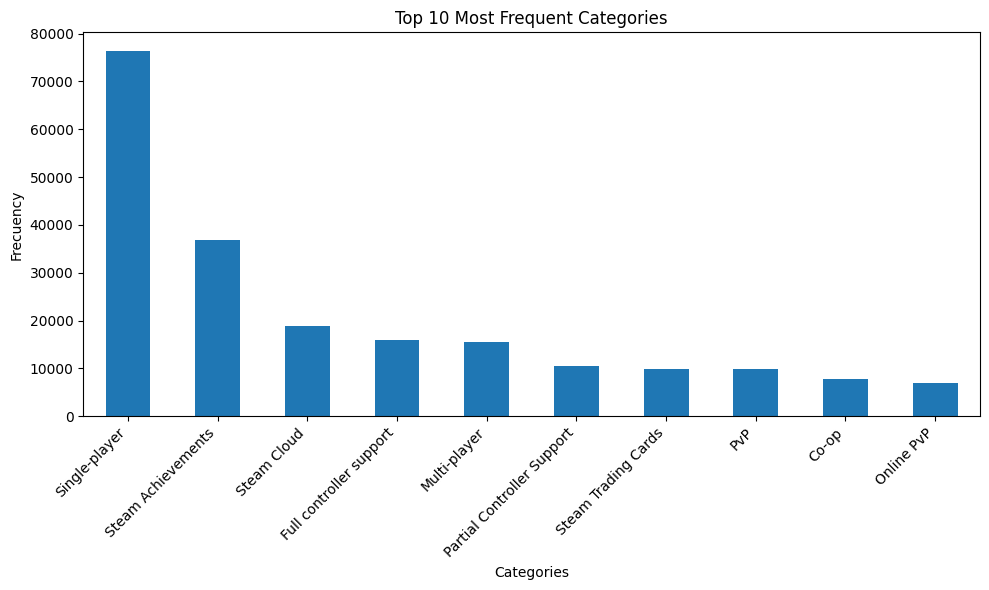

In [16]:
games_categorias = games['Categories'].str.split(', ', expand=True).stack()

# Contar la frecuencia de cada categoría individual
frecuencia_categorias = games_categorias.value_counts()

# Seleccionar las 10 categorías más frecuentes
top_10_categorias = frecuencia_categorias.head(10)

# Graficar las 10 categorías más frecuentes
plt.figure(figsize=(10, 6))
top_10_categorias.plot(kind='bar')
plt.title('Top 10 Most Frequent Categories')
plt.xlabel('Categories')
plt.ylabel('Frecuency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
games_last_5_years = games[games['ReleaseDate'].dt.year >= current_year - 5]

category_counts = games_last_5_years['Categories'].str.split(', ').explode().value_counts()

# Seleccionar las 10 categorías más frecuentes
top_categories = category_counts.head(6)

# Calcular los porcentajes de ocurrencia de cada categoría
category_percentages = (top_categories / top_categories.sum()) * 100

# Crear un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Categorías más Usadas en los Últimos 5 Años')
plt.axis('equal')  # Para que el gráfico sea circular
plt.tight_layout()
plt.show()

NameError: name 'current_year' is not defined

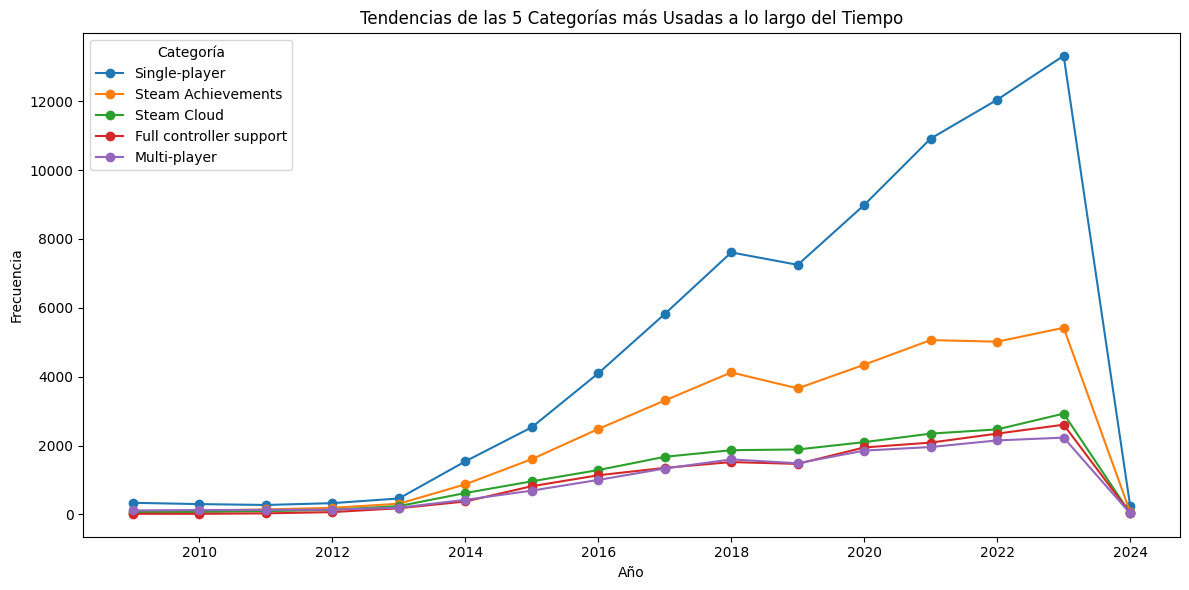

In [19]:
current_year = pd.Timestamp.now().year

# Filtrar los datos para los últimos 5 años
games_last_5_years = games[games['ReleaseDate'].dt.year >= current_year - 15]

# Calcular la frecuencia de cada categoría en los últimos 5 años
category_counts = games_last_5_years['Categories'].str.split(', ').explode().value_counts()

# Seleccionar las 5 categorías más usadas
top_5_categories = category_counts.head(5)

# Crear una lista con los nombres de las 5 categorías más usadas
top_5_category_names = top_5_categories.index.tolist()

# Crear un DataFrame para almacenar las tendencias de las 5 categorías más usadas
trends_top_5_categories = pd.DataFrame(index=range(current_year - 15, current_year + 1))

# Calcular la frecuencia de cada categoría para cada año
for category_name in top_5_category_names:
    trends_top_5_categories[category_name] = games_last_5_years[games_last_5_years['Categories'].str.contains(category_name)]['ReleaseDate'].dt.year.value_counts().sort_index()

# Graficar las tendencias de las 5 categorías más usadas a lo largo del tiempo
plt.figure(figsize=(12, 6))
trends_top_5_categories.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Tendencias de las 5 Categorías más Usadas a lo largo del Tiempo')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.legend(title='Categoría', loc='upper left')
plt.tight_layout()
plt.show()

Genres

In [28]:
games['Genres'].fillna('Not specified', inplace=True)

C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_5636\3707862236.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['Genres'].fillna('Not specified', inplace=True)


In [24]:
nulls_genres = games[games['Genres'].isna()]
print('Genres:', len(nulls_genres))

Genres: 0


In [25]:
def separar_genres(cadena):
    return cadena.split(',')

# Aplicar la función a la columna 'categories' y luego unir las listas resultantes en una cadena
games['Genres'] = games['Genres'].apply(separar_genres).apply(', '.join)

In [26]:
def count_categories(games):
    # Dividir las categorías y contar su frecuencia
    categories = games['Genres'].str.split(', ')
    all_categories = [category for sublist in categories.dropna() for category in sublist]
    category_counts = pd.Series(all_categories).value_counts()
    
    return category_counts

# Obtener la frecuencia de las categorías
category_counts = count_categories(games)

# Imprimir la frecuencia de las categorías
print(category_counts.to_string())

Indie                    56929
Casual                   34208
Action                   33808
Adventure                31450
Simulation               16146
Strategy                 15602
RPG                      14439
Early Access             10403
Free to Play              6630
Sports                    3790
Not specified             3553
Racing                    3095
Massively Multiplayer     2177
Utilities                  846
Violent                    527
Design & Illustration      500
Animation & Modeling       414
Education                  399
Gore                       311
Video Production           290
Game Development           238
Software Training          207
Audio Production           202
Photo Editing              137
Nudity                     120
Web Publishing             110
Sexual Content             108
Accounting                  23
Movie                        2
Documentary                  1
Episodic                     1
Short                        1
Tutorial

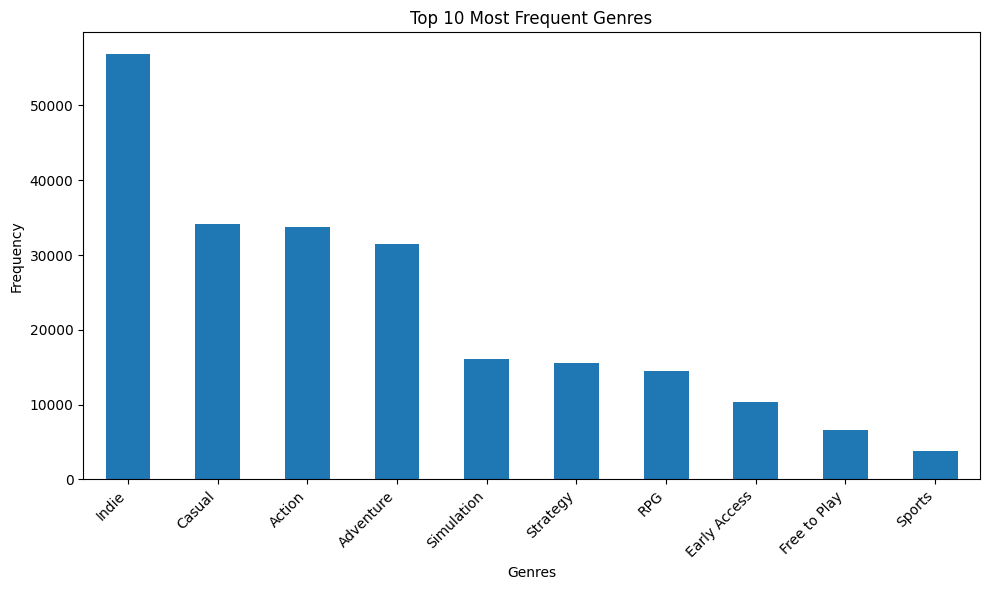

In [27]:
genre_counts = count_categories(games)

# Seleccionar las 10 categorías más frecuentes
top_10_genres = genre_counts.head(10)

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
top_10_genres.plot(kind='bar')
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Estimated Owners

In [56]:
games['EstimatedOwners'].value_counts()

EstimatedOwners
0 - 20000                55284
0 - 0                    11499
20000 - 50000             7808
50000 - 100000            3886
100000 - 200000           2566
200000 - 500000           2142
500000 - 1000000           906
1000000 - 2000000          521
2000000 - 5000000          329
5000000 - 10000000          92
10000000 - 20000000         38
20000000 - 50000000         21
50000000 - 100000000         4
100000000 - 200000000        1
Name: count, dtype: int64

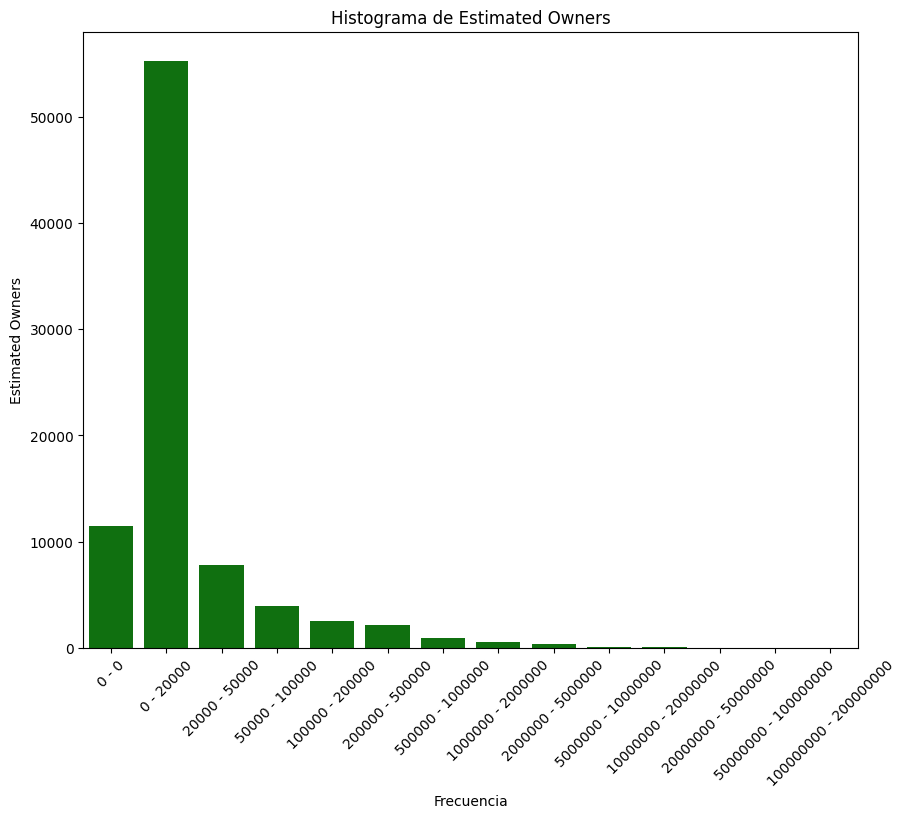

In [55]:
# Definir el orden correcto de las categorías
order = ['0 - 0', '0 - 20000', '20000 - 50000', '50000 - 100000',
         '100000 - 200000', '200000 - 500000', '500000 - 1000000',
         '1000000 - 2000000', '2000000 - 5000000', '5000000 - 10000000',
         '10000000 - 20000000', '20000000 - 50000000', '50000000 - 100000000', '100000000 - 200000000']

# Convertir la columna 'EstimatedOwners' a una categoría ordenada
games['EstimatedOwners'] = pd.Categorical(games['EstimatedOwners'], categories=order, ordered=True)

# Ordenar el DataFrame por la nueva columna 'EstimatedOwners'
games_sorted = games.sort_values(by='EstimatedOwners')

# Crear el gráfico de barras con Seaborn y ajustar el tamaño
plt.figure(figsize=(10, 8))
sns.countplot(x='EstimatedOwners', data=games_sorted, color='green')

plt.xticks(rotation=45)

# Añadir etiquetas y título
plt.xlabel('Frecuencia')
plt.ylabel('Estimated Owners')
plt.title('Histograma de Estimated Owners')

# Mostrar el gráfico de barras
plt.show()


### Peak CCU

In [47]:
games['PeakCCU'].unique()

array([   0,   68,    3, ..., 4753, 1876, 1135], dtype=int64)

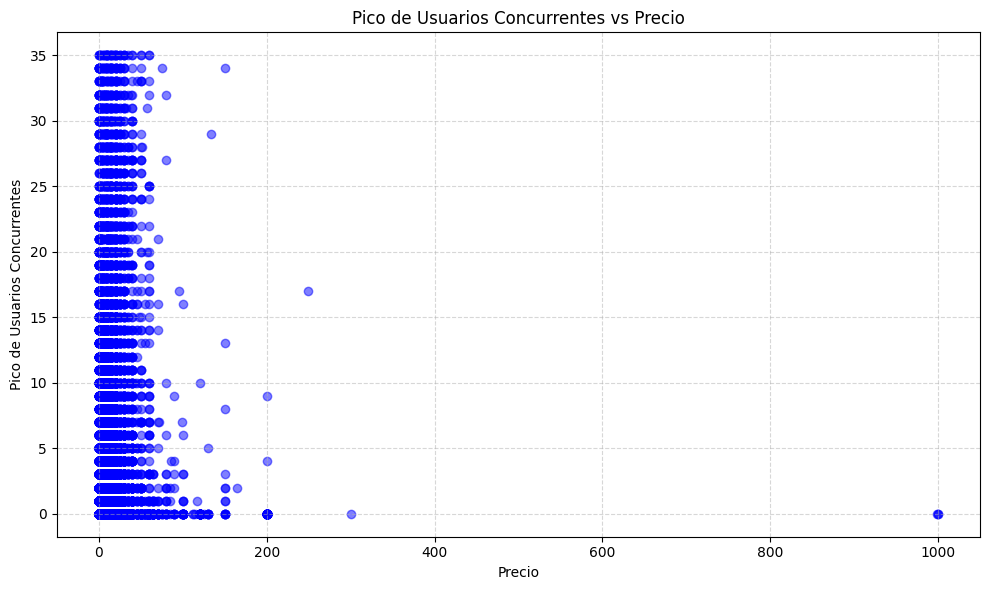

In [9]:
games = games[games['PeakCCU'] < games['PeakCCU'].quantile(0.95)]

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(games['Price'], games['PeakCCU'], color='blue', alpha=0.5)
plt.title('Pico de Usuarios Concurrentes vs Precio')
plt.xlabel('Precio')
plt.ylabel('Pico de Usuarios Concurrentes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

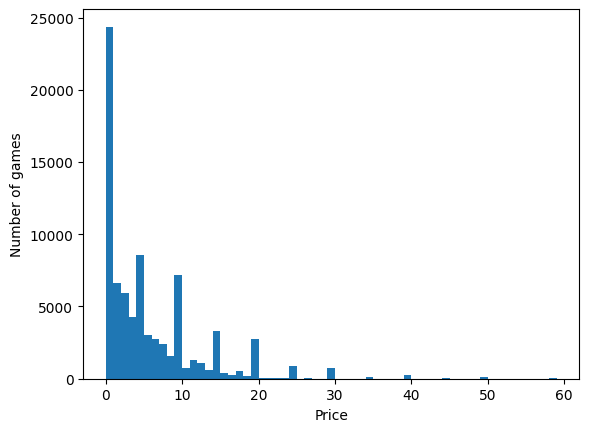

In [12]:
plt.hist(games['Price'], bins=list(range(0, 60)))
plt.xlabel('Price')
plt.ylabel('Number of games')
plt.show()

In [11]:
print(games['Price'].value_counts())

Price
0.00      15920
4.99       7616
9.99       6931
0.99       6468
1.99       5155
          ...  
124.99        1
1.22          1
8.88          1
1.85          1
2.20          1
Name: count, Length: 556, dtype: int64


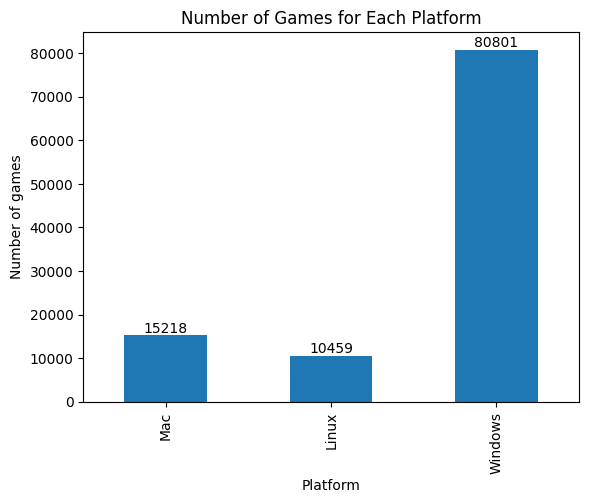

In [10]:
platform_counts = games[['Mac', 'Linux', 'Windows']].sum()

ax = platform_counts.plot(kind='bar')
for i, v in enumerate(platform_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.xlabel('Platform')
plt.ylabel('Number of games')
plt.title('Number of Games for Each Platform')
plt.show()

### Developers 

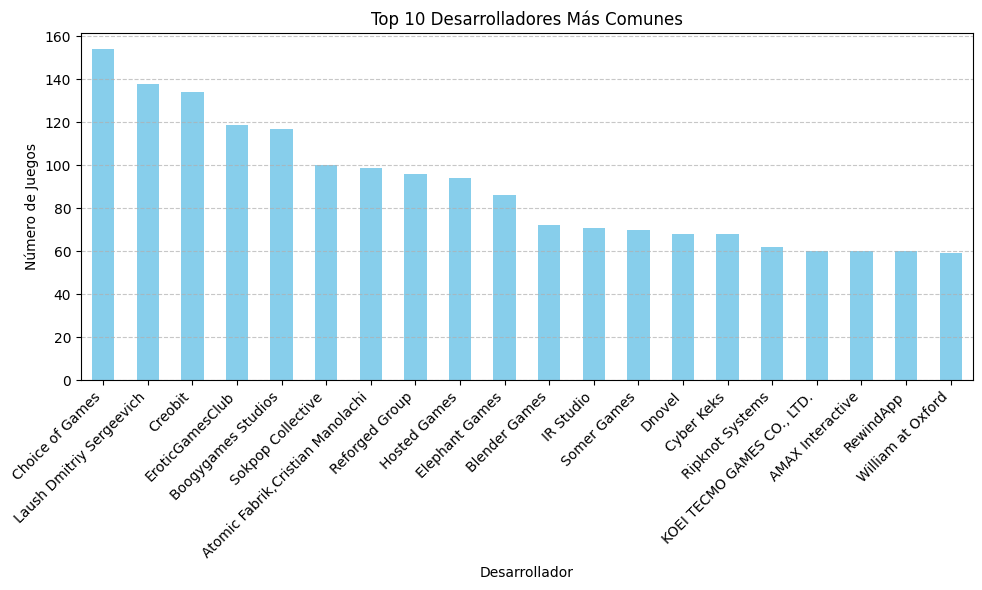

In [27]:
developers_frecuencia = games['Developers'].value_counts()

# Tomar los 10 primeros desarrolladores más comunes para mantener el gráfico legible
top_developers = developers_frecuencia.head(20)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
top_developers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Desarrolladores Más Comunes')
plt.xlabel('Desarrollador')
plt.ylabel('Número de Juegos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Positive 